# Footprints of Bulk ATAC-seq

ATAC-seq (Assay for Transposase-Accessible Chromatin using high-throughput sequencing) is a sequencing assay for investigating genome-wide chromatin accessibility. The assay applies a Tn5 Transposase to insert sequencing adapters into accessible chromatin, enabling mapping of regulatory regions across the genome. Additionally, the local distribution of Tn5 insertions contains information about transcription factor binding due to the visible depletion of insertions around sites bound by protein - known as footprints.

In [1]:
import os
os.environ["EPIONE_DATA_DIR"] = "/Users/fernandozeng/Desktop/analysis/25_epione/code/tutorial/genome"


import epione as epi
import snapatac2 as snap
import scanpy as sc
import matplotlib.pyplot as plt

epi.pl.plot_set()

%load_ext autoreload
%autoreload 2

└─ 🔬 Starting plot initialization...
  ├─ Apply Scanpy/matplotlib settings
  ├─ Custom font setup
  ├─ Suppress warnings
  ├─ 
___________      .__                      
\_   _____/_____ |__| ____   ____   ____  
 |    __)_\____ \|  |/  _ \ /    \_/ __ \ 
 |        \  |_> >  (  <_> )   |  \  ___/ 
/_______  /   __/|__|\____/|___|  /\___  >
        \/|__|                  \/     \/ 

  ├─ 🔖 Version: 0.0.1rc1   📚 Tutorials: https://epione.readthedocs.io/
└─ ✅ plot_set complete.



## ATAC correct

Similar to other enzymes used in chromatin accessibility assays (e.g. DNaseI for DNase-seq), the Tn5 transposase harbours an inherent insertion bias. This means that while we assume insertion frequency to be driven by accessibility alone, the local cutting pattern is largely driven by the underlying sequence. This interferes with footprinting analysis, and should therefore be corrected.

The ATACorrect tool corrects this bias to yield a corrected signal, which simultanously serves to identify regions "less cut than expected", indicating regions of Tn5 protection due to protein binding. An overview of the estimation is seen here:

In [ ]:
results = epi.tl.atacorrect(
    bam_file='data-tobias-2020/Bcell.bam',
    fasta_file='data-tobias-2020/genome.fa.gz',
    peak_bed_file='data-tobias-2020/merged_peaks.bed',
    output_prefix="result/atacorrect_example",
    k_flank=12,
    score_mat="DWM",
    verbose=True
)

In [4]:
bw_dict={
    'example_corrected':'result/atacorrect_example_corrected.bw',
}
bw_obj=epi.bulk.bigwig(bw_dict)
bw_obj.read()

└─ Load bigWig files
  └─ Loading example_corrected...


In [5]:
bw_obj.load_gtf('data-tobias-2020/genes.gtf')

└─ Load GTF file
  ├─ Reading GTF...
  └─ Reading GTF file from data-tobias-2020/genes.gtf...
  └─ GTF file read successfully
  └─ GTF loaded


In [6]:
color_dict={
    'example_corrected':epi.pl.green_color[2],
}

(<Figure size 480x240 with 2 Axes>,
 array([<Axes: ylabel='Bcell'>, <Axes: >], dtype=object))

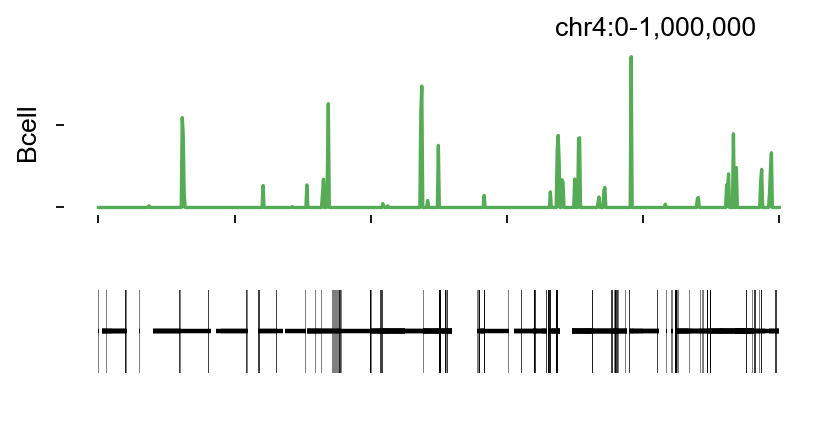

In [13]:
%matplotlib inline
bw_obj.plot_track(chrom='chr4',chromstart=0,chromend=1000000,
                  plot_names=['Bcell'],figwidth=6,figheight=1.5,
                  color_dict=color_dict,
                  )

## Score bigwig

The main task in footprinting is to identify regions of protein binding across the genome. Using single basepair cutsite tracks (as produced by ATACorrect), ScoreBigwig is used to calculate a continuous footprinting score across regions. The calculation of the footprint score is as follows:

This score takes into account the depletion of signal (negative counts), while also including the general accessibility of the nearby region. This helps to improve binding prediction for transcription factors with low footprintability (i.e. showing weak footprints). It is therefore important to note is that if there is no depletion, the score will converge to the accessibility of the flanking regions. A clear shape of a footprint is therefore not a necessity for a high footprint score to occur.

In [2]:
tobias_scores = epi.tl.score_bigwig(
    signal_file='result/atacorrect_example_corrected.bw',
    regions_bed='data-tobias-2020/merged_peaks.bed',
    output_file="result/tobias_scores.bw",
    method="tobias",
    n_cores=8,
)

Calculating TOBIAS footprint scores...
- Signal file: result/atacorrect_example_corrected.bw
- Regions: 6007
- Using 8 cores


Processing regions (parallel): 100%|████████████| 6007/6007 [00:25<00:00, 237.54it/s]


Saved scores to result/tobias_scores.bw
Completed scoring 6007 regions

Summary Statistics:
- Regions processed: 6007
- Total positions: 2351627
- Valid scores: 2351627
- Mean score: 0.584
- Score range: [0.000, 10.823]


In [3]:
bw_dict={
    'example_corrected':'result/tobias_scores.bw',
}
bw_obj=epi.bulk.bigwig(bw_dict)
bw_obj.read()

└─ Load bigWig files
  └─ Loading example_corrected...


In [4]:
bw_obj.load_gtf('data-tobias-2020/genes.gtf')

└─ Load GTF file
  ├─ Reading GTF...
  └─ Reading GTF file from data-tobias-2020/genes.gtf...
  └─ GTF file read successfully
  └─ GTF loaded


In [5]:
color_dict={
    'example_corrected':epi.pl.green_color[2],
}

(<Figure size 480x240 with 2 Axes>,
 array([<Axes: ylabel='Bcell'>, <Axes: >], dtype=object))

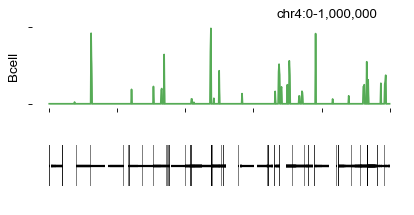

In [6]:
%matplotlib inline
bw_obj.plot_track(chrom='chr4',chromstart=0,chromend=1000000,
                  plot_names=['Bcell'],figwidth=6,figheight=1.5,
                  color_dict=color_dict,
                  )

## BinDetect

To make predictions on specific transcription factor binding, we need to combine footprint scores with the information of transcription factor binding motifs. This will enable us to estimate the binding positions of individual transcription factors across the genome. Simultanously, if we have multiple conditions, we are interested in the differential binding of transcription factors, both globally and at single sites. BINDetect is a tool to integrate these different sources of information to predict transcription factor binding across multiple conditions:

In [19]:
results = epi.tl.bindetect(
    condition_names=['Bcell','Tcell'],
    score_files=['data-tobias-2020/Bcell_footprints.bw',
                'data-tobias-2020/Tcell_footprints.bw'],
    motif_file='data-tobias-2020/motifs.jaspar',
    fasta_file='data-tobias-2020/genome.fa.gz',
    regions_bed='data-tobias-2020/merged_peaks_annotated.bed',
    output_dir="bindetect_results_Bcell1",
    #target_tf='BATF',
    #motif_threshold=0.8,
    #p_value_threshold=0.05
)

└─ Starting BINDetect analysis...
└─ Processing input data
  └─ Found 6007 regions in input peaks
      └─ Peaks have 8 columns
      └─ Peak header list: ['peak_chr', 'peak_start', 'peak_end', 'additional_1', 'additional_2', 'additional_3', 'additional_4', 'additional_5']
  └─ GC content estimated at 47.61%
  └─ Read 83 motifs
  └─ Plotting sequence logos for each motif


Creating logos: 100%|████████████████████████████████| 83/83 [00:02<00:00, 35.06it/s]


└─ Scanning for motifs and matching to signals...


Scanning regions: 100%|██████████████████████████████| 99/99 [00:02<00:00, 46.98it/s]


└─ Processing background scores
└─ Normalizing scores across conditions
└─ Estimating bound/unbound threshold
  └─ Threshold estimated at: 10.7384
└─ Calculating differential binding statistics
└─ Processing scanned TFBS individually


Processing TFs: 100%|████████████████████████████████| 83/83 [00:11<00:00,  7.24it/s]


└─ Writing results files
└─ Creating plots
  └─ BINDetect analysis completed!


[PlotAggregate] INFO: ---- Processing input ----
[PlotAggregate] INFO: Reading information from .bed-files
[PlotAggregate] STATS: COUNT BATF_MA1634.1_all: 990 sites
[PlotAggregate] INFO: Reading signal from bigwigs
[PlotAggregate] INFO: - Reading signal from Bcell
[PlotAggregate] INFO: - Reading signal from Tcell
[PlotAggregate] INFO: Calculating aggregate signals
[PlotAggregate] INFO: ---- Plotting aggregates ----
[PlotAggregate] INFO: Setting up plotting grid
[PlotAggregate] INFO: Plotting regions BATF_MA1634.1_all from signal Bcell
[PlotAggregate] INFO: Plotting regions BATF_MA1634.1_all from signal Tcell
[PlotAggregate] INFO: Adjusting final details
[PlotAggregate] INFO: Saved plot to result/epione_test_output.pdf


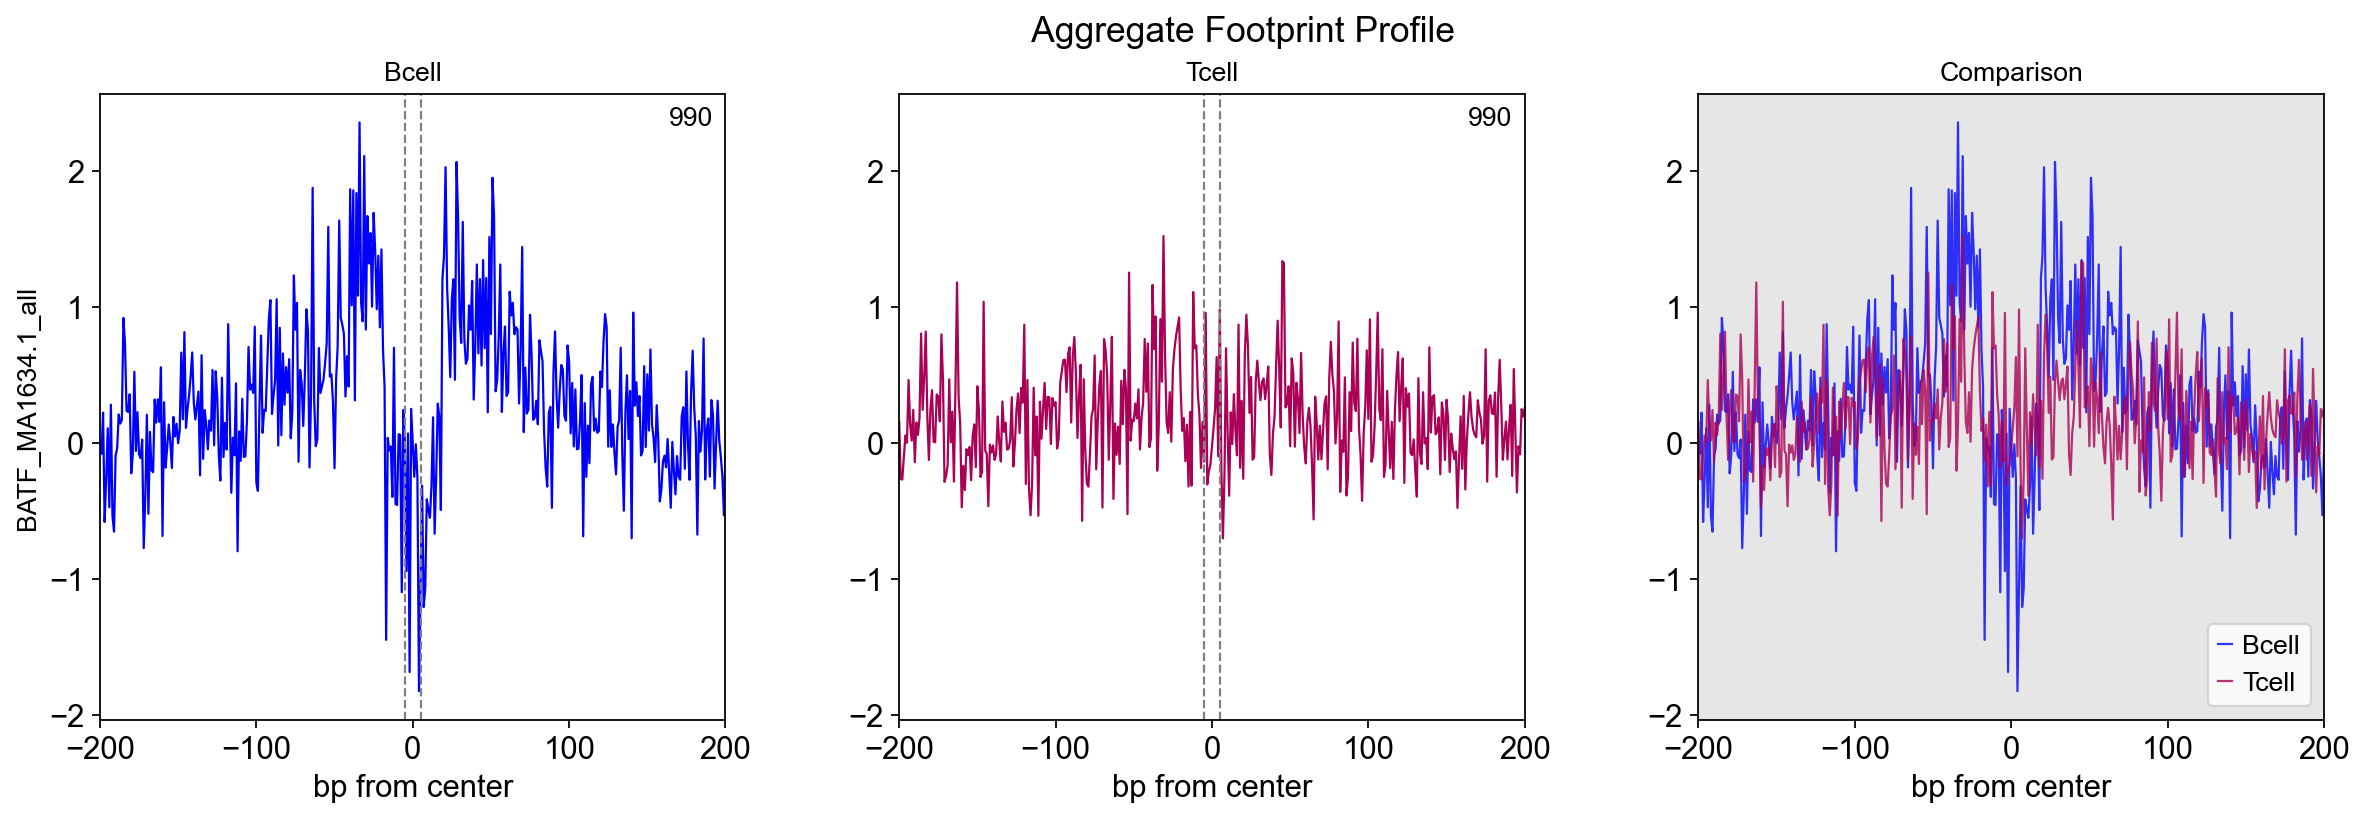

In [6]:
# Aggregate plot
fig1 = epi.tl.plot_aggregate(
    bigwig_files=['data-tobias-2020/Bcell_corrected.bw',
                 'data-tobias-2020/Tcell_corrected.bw',],
    regions_bed='bindetect_results_Bcell1/BATF_MA1634.1/beds/BATF_MA1634.1_all.bed',
    #output_file="result/test_aggregate_plot.png",
    output_file="result/epione_test_output.pdf",
    labels=["Bcell","Tcell"],
    title="Aggregate Footprint Profile",
    flank=200,
    signal_on_x=True,
    share_y="both",
    plot_boundaries=True,
    normalize=False,
)
fig1